# Black-Litterman allocation

The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio.

For a description of the theory, please read the [documentation page](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and the links therein.

In this recipe, we will cover:

- Downloading data for the Black-Litterman method
- Constructing the prior return vector based on market equilibrium
- Two ways of constructing the uncertainty matrix
- Combining Black-Litterman with mean-variance optimization

## Downloading data

In addition to price data, constructing a market prior requires market-caps.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"]

In [3]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  10 of 10 completed


,AMZN,BAC,COST,DIS,DPZ,KO,MCD,MSFT,NAT,SBUX
Date,,,,,,,,,,
2023-04-24,106.209999,29.760000,511.420013,99.680000,330.269989,63.950001,293.200012,281.769989,3.77,109.290001
2023-04-25,102.570000,28.840000,503.170013,98.010002,329.630005,63.849998,291.510010,275.420013,3.63,109.339996
2023-04-26,104.980003,28.440001,494.660004,96.610001,339.029999,63.549999,289.760010,295.369995,3.51,111.470001
2023-04-27,109.820000,28.889999,501.269989,99.930000,317.140015,63.680000,294.720001,304.829987,3.50,112.750000
2023-04-28,105.449997,29.280001,503.220001,102.500000,317.470001,64.150002,295.750000,307.260010,3.53,114.290001


In [4]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    25.122347
1993-02-01    25.301029
1993-02-02    25.354637
1993-02-03    25.622635
1993-02-04    25.729849
Name: Adj Close, dtype: float64

In [5]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MSFT': 2284628738048,
 'AMZN': 1081706086400,
 'NAT': 737049856,
 'BAC': 233433055232,
 'DPZ': 11244279808,
 'DIS': 187248017408,
 'KO': 277421817856,
 'MCD': 215906959360,
 'COST': 223169527808,
 'SBUX': 131353493504}

## Constructing the prior

In [6]:
import pypfopt
pypfopt.__version__

'1.5.2'

In [7]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.5412199245233515

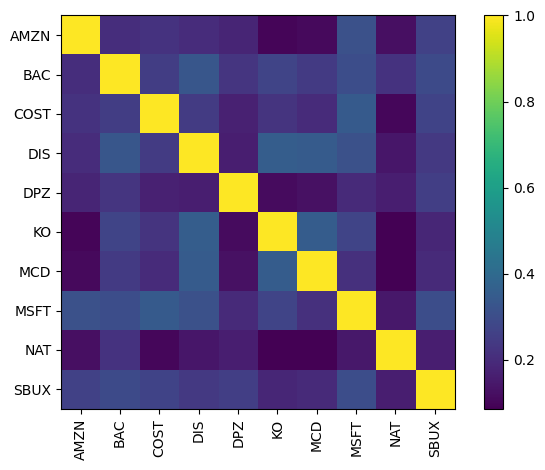

In [8]:
plotting.plot_covariance(S, plot_correlation=True);

In [9]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AMZN    0.153288
BAC     0.099106
COST    0.077011
DIS     0.092642
DPZ     0.047818
KO      0.064515
MCD     0.068432
MSFT    0.140092
NAT     0.050765
SBUX    0.078862
dtype: float64

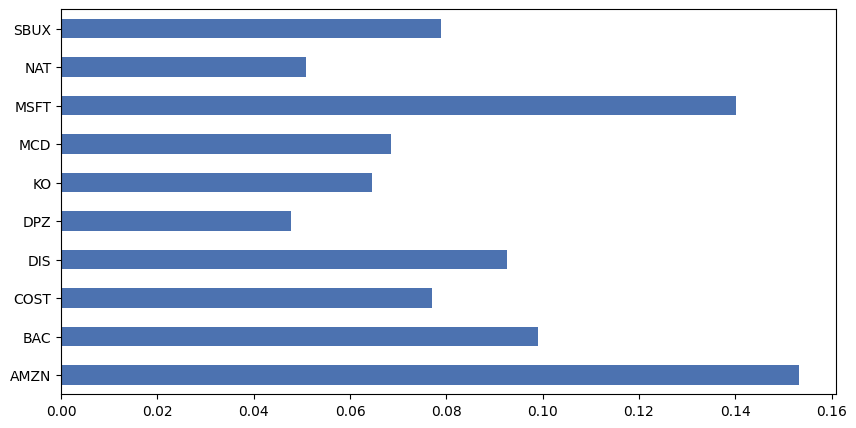

In [10]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [11]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [12]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [13]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

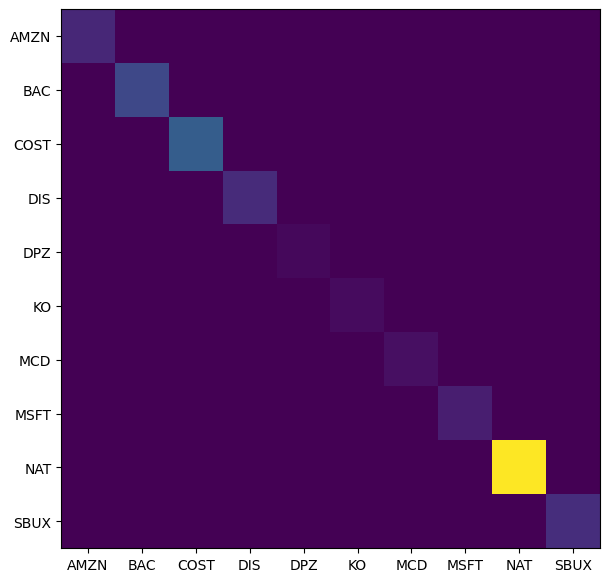

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [15]:
np.diag(bl.omega)

array([0.00461475, 0.00889163, 0.01215993, 0.00498129, 0.00085369,
       0.00114708, 0.00171296, 0.00348085, 0.04108595, 0.005412  ])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [16]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [17]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [18]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [19]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AMZN    0.136179
BAC     0.130071
COST    0.061436
DIS     0.071603
DPZ     0.103862
KO      0.008256
MCD     0.103908
MSFT    0.103966
NAT     0.061059
SBUX    0.082103
dtype: float64

We can visualise how this compares to the prior and our views:

In [20]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.153288,0.136179,0.10
BAC,0.099106,0.130071,0.30
COST,0.077011,0.061436,0.05
DIS,0.092642,0.071603,0.05
DPZ,0.047818,0.103862,0.20
KO,0.064515,0.008256,-0.05
MCD,0.068432,0.103908,0.15
MSFT,0.140092,0.103966,0.10
NAT,0.050765,0.061059,0.50
SBUX,0.078862,0.082103,0.10


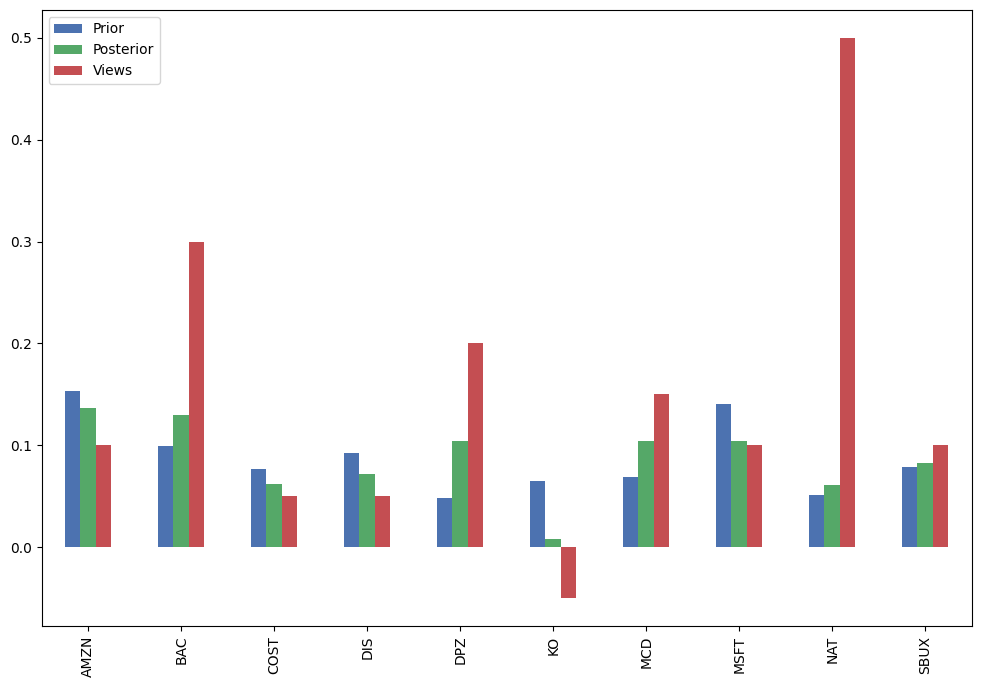

In [21]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

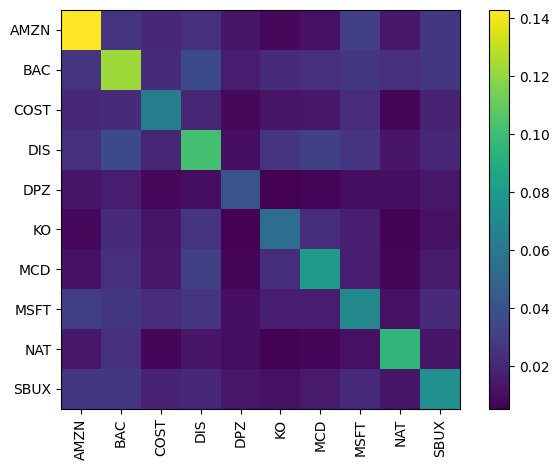

In [22]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [23]:
from pypfopt import EfficientFrontier, objective_functions

In [24]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

c:\Users\Viacheslav Dziadok\.conda\envs\PortOpt\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AMZN', 0.17206),
             ('BAC', 0.16233),
             ('COST', 0.05657),
             ('DIS', 0.06592),
             ('DPZ', 0.1388),
             ('KO', 0.0),
             ('MCD', 0.13066),
             ('MSFT', 0.1271),
             ('NAT', 0.05757),
             ('SBUX', 0.089)])

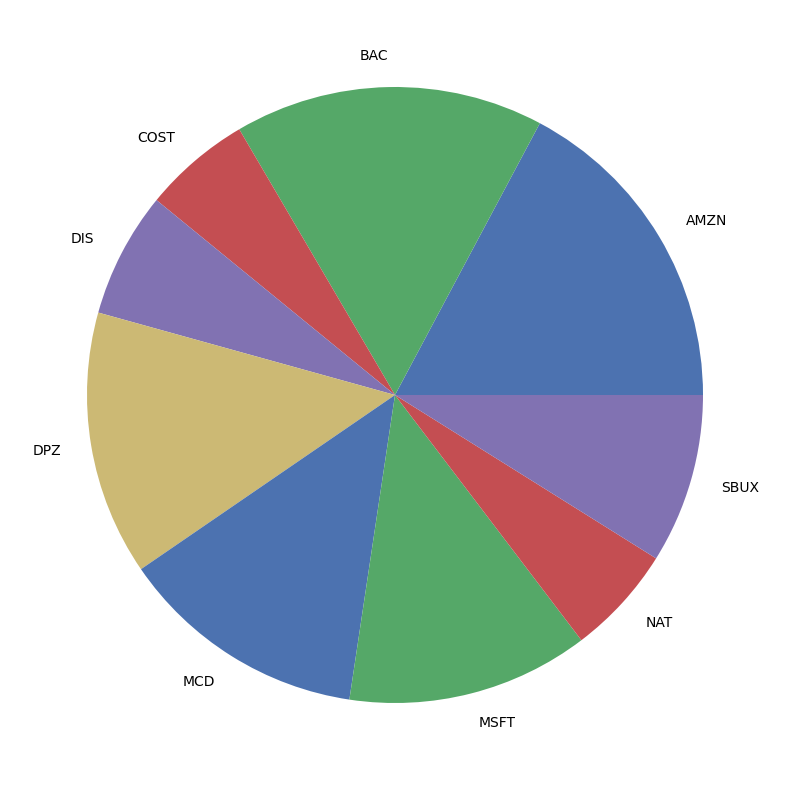

In [25]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [26]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $0.40


{'AMZN': 33,
 'BAC': 110,
 'COST': 2,
 'DIS': 13,
 'DPZ': 9,
 'MCD': 9,
 'MSFT': 8,
 'NAT': 327,
 'SBUX': 16}